In [1]:
# this is the pipeline of phenotype analysis
import sys
sys.path.append('..')
import os
import pandas as pd
import copy
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tree_util

In [2]:
def fr(d_df, profile, sname):
    sp_list = list(profile.columns)
    sp_d_df = d_df.loc[sp_list, sp_list]
    #print(profile)
    sp_profile = np.array(profile.loc[sname, sp_list])
    value = np.dot(sp_profile.reshape(len(sp_profile), 1),sp_profile.reshape(1, len(sp_profile)))
    width = value.shape[0]
    cor_df = np.ones(shape=(width, width)) - sp_d_df.values
    for i in range(width):
        cor_df[i][i] = 0
    value = np.multiply(value, cor_df)
    df = pd.DataFrame(data= value, index=sp_list, columns=sp_list)
    return df

def nfr(d_df, profile, sname):
    sp_list = list(profile.columns)
    n = len(sp_list)
    corr = np.ones(shape=(n, n)) - d_df.loc[sp_list, sp_list].values
    np.fill_diagonal(corr, 0)
    # print(corr[1, 1])
    a = np.array(profile.loc[sname, sp_list])
    inter_matrix = np.dot(a.reshape(len(a), 1),a.reshape(1, len(a)))
    np.fill_diagonal(inter_matrix, 0)
    td = np.sum(inter_matrix)/2
    fr = np.sum(np.multiply(inter_matrix, corr))/2
    fd = np.sum(np.multiply(inter_matrix, d_df.loc[sp_list, sp_list].values))/2
    if td == 0:
        return 0
    return fr, td, fd

def multisample_nfr(profile, d_df, node_leaves):
    result = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys()) + ['nroot']))
    result2 = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys()) + ['nroot']))
    result3 = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys()) + ['nroot']))
    for sname in profile.index:
       for node, sp_list in node_leaves.items():
           sp_list = list(set(sp_list).intersection(set(profile.columns)))
           selected_d = d_df.loc[sp_list, sp_list]
           selected_profile = profile.loc[:, sp_list]
           value, td, fd = nfr(selected_d, selected_profile, sname)
           result.loc[sname, node] = value/td
           result2.loc[sname, node] = td
           result3.loc[sname, node] = fd
    return result, result2, result3


In [3]:
outdir = '../result/FMT/nFR/FMT1_root'
if not os.path.exists(outdir):
    os.makedirs(outdir)
with open('../result/GCN_fix_tree/renamed_GCN_tree.newick') as fp:
    newick_tree = fp.read()
    # newick_tree = newick_tree.replace('-', '_')

json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
layer_leaves_dict = tree_util.make_layer_dict(nlayer)
tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
leaves_dict = copy.deepcopy(layer_leaves_dict)
parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

In [4]:
d_df = pd.read_csv('../data/sp_d.tsv', sep='\t', header=0, index_col=0)
metadata = pd.read_csv('../data/FMT/FMT1/metadata.tsv', sep='\t', index_col=None, header=0)
abd = pd.read_csv('../data/FMT/FMT1/fmt_abd.tsv', sep='\t', header=0, index_col=0)
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
d_df = d_df.rename(columns=name_dict, index=name_dict)
abd = abd.rename(columns=name_dict)
sub_ids = ['FAT_006', 'FAT_015', 'FAT_008', 'FAT_020', 'FAT_012']
days = [0, 2, 14, 42, 84]
frac_df = pd.read_csv('../data/FMT/FMT1/Li.txt', sep='\t', header=0, index_col=0)
param = 0.5

In [5]:
profile = abd[list(set(abd.columns).intersection(set(d_df.columns)))]/100
rename_dict = {}
ids = []
for id in sub_ids:
    sid = "{}-22-0-0".format(id)
    ids.append(sid)
    rename_dict[sid] = 'FMT{}'.format(len(ids))
profile = profile.loc[ids, ].rename(index=rename_dict)
profile.to_csv(os.path.join(outdir, 'abd.tsv'), sep='\t')
node_leaves = {'root': leaf_list}
se_df, se_df2, se_df3 = multisample_nfr(profile, d_df, node_leaves)
se_df = se_df.T
se_df = se_df.drop('nroot')
se_df2 = se_df2.drop('nroot', axis=1)
se_df3 = se_df3.drop('nroot', axis=1)
se_df.to_csv(os.path.join(outdir, 'nfr.tsv'), sep='\t')
se_df2.to_csv(os.path.join(outdir, 'td.tsv'), sep='\t')
se_df3.to_csv(os.path.join(outdir, 'fd.tsv'), sep='\t')
se_dict = {'nfr': se_df, 'td': se_df2.T, 'fd': se_df3.T}

In [6]:
p_cutoff = 0.05
# compute frac and t

tmp = 'Fraction of donor specific strains ({} days post FMT)'
frac = []
t = []
for day in days:
    if day == 0:
        continue
    post_day = tmp.format(day)
    frac += list(frac_df[post_day])
    t += [day] * len(frac_df)

elist = ['td', 'fd', 'nfr']
e_dict = {}
for e in elist:
    e_dict[e] = pd.DataFrame(columns=['F-pvalue', '{}_co'.format(e), 't_co', 'const_co', '{}_p'.format(e), 't_p', 'const_p'])

for node in node_leaves.keys():
    df = pd.DataFrame()
    se = list(se_df.loc[node, ])
    td = list(se_df2[node])
    fd = list(se_df3[node])
    se_vector = []
    td_vector = []
    fd_vector = []
    for day in days:
        if day == 0:
            continue
        se_vector += se
        td_vector += td
        fd_vector += fd
    if sum(se) == 0:
        continue
    df = pd.DataFrame()
    df['frac'] = frac
    df['nfr'] = se_vector
    df['fd'] = fd_vector
    df['td'] = td_vector
    df['t'] = t

    for e in elist:
        X = df[[e, 't']]
        y = df['frac']
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        result = model.fit()

        e_dict[e].loc[node, 'F-pvalue'] = result.f_pvalue
        for var in result.pvalues.index:
            e_dict[e].loc[node, "{}_co".format(var)] = result.params[var]
            e_dict[e].loc[node, "{}_p".format(var)] = result.pvalues[var]
for e, odf in e_dict.items():
    odf.sort_values(by='F-pvalue').to_csv(os.path.join(outdir, '{}_p_values.tsv'.format(e)), index=True, header=True, sep='\t')

In [7]:
for e, odf in e_dict.items():
    print(odf[odf['F-pvalue']<p_cutoff])

     F-pvalue     td_co      t_co const_co      td_p       t_p   const_p
root  0.02778 -1.417132 -0.000777  0.89214  0.011053  0.387507  0.000789
Empty DataFrame
Columns: [F-pvalue, fd_co, t_co, const_co, fd_p, t_p, const_p]
Index: []
Empty DataFrame
Columns: [F-pvalue, nfr_co, t_co, const_co, nfr_p, t_p, const_p]
Index: []


<ipython-input-8-70cf86fa98f0>:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-8-70cf86fa98f0>:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-8-70cf86fa98f0>:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


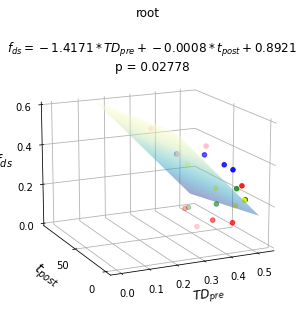

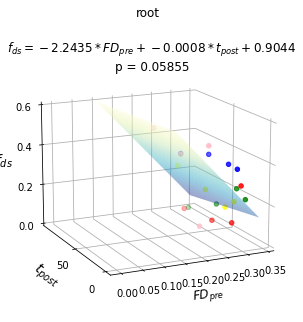

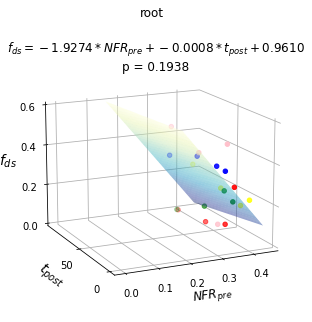

In [8]:
color_dict = {
    1: 'r', 
    2: 'g', 
    3: 'b', 
    4: 'pink', 
    5:'yellow', 
}

elist = ['td', 'fd', 't']
for e, odf in e_dict.items():
    formula_tmp = r'$f_{{ds}} = {:.4f}*{}_{{pre}} + {:.4f}*t_{{post}} + {:.4f}$' + '\np = {:.4}'

    for node in sorted(list(odf.index)):
        se = []
        se_tmp = list(se_dict[e].loc[node, ])
        if sum(se_tmp) == 0:
            continue
        for day in days:
            if day == 0:
                continue
            se += se_tmp

        se_co = odf.loc[node, '{}_co'.format(e)]
        t_co = odf.loc[node, 't_co']
        const = odf.loc[node, 'const_co']
        p_value = odf.loc[node, 'F-pvalue']
        se = np.linspace(0, max(max(se)*1.1, 0.05), 1000)
        t = np.linspace(0, 100, 1000)
        X, Y = np.meshgrid(se, t)
        f = se_co*X + t_co*Y + const
        f[f>0.6] = np.nan
        f[f<0] = np.nan
        formula = formula_tmp.format(se_co, e.upper(), t_co, const, p_value)
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='3d')
        cmp = plt.cm.YlGnBu_r
        surf = ax.plot_surface(X, Y, f, cmap=cmp, alpha=0.5)
        surf.set_clim(0, 0.6)
        ax.set_yticks(np.arange(0, 100, 50))
        ax.set_yticklabels(np.arange(0, 100, 50))

        ax.set_zlim((0, 0.6))
        ax.set_zticks(np.array([0, 0.2, 0.4, 0.6]))
        ax.set_zticklabels(np.array([0, 0.2, 0.4, 0.6]))

        ax.set_xlabel(r'${}_{{pre}}$'.format(e.upper()), fontweight='bold', fontsize=12)
        ax.set_ylabel(r'$t_{post}$', fontweight='bold', fontsize=14)
        ax.zaxis.set_rotate_label(False) 
        ax.set_zlabel(r'$f_{ds}$', fontweight='bold', fontsize=14)

        tmp = 'Fraction of donor specific strains ({} days post FMT)'
        frac = []
        t = []
        for day in days:
            if day == 0:
                continue
            post_day = tmp.format(day)
            frac += list(frac_df[post_day])
            t += [day] * len(frac_df)
        se = []
        colors = []
        for day in days:
            if day == 0:
                continue
            se += se_tmp
            for i in range(1, 6):
                colors.append(color_dict[i])
        point_df = pd.DataFrame(columns=['sample', 'nFR_pre', 't_post', 'f_ds'])
        slist = ['FMT{}'.format(i) for i in range(1, 6)] * (len(days) - 1)
        point_df['sample'] = slist
        point_df['{}_pre'.format(e)] = se
        point_df['t_post'] = t
        point_df['f_ds'] = frac
        point_df.to_csv(os.path.join(outdir, '{}.tsv'.format(node)), sep='\t', header=True, index=False)

        ax.scatter(se, t, frac, c = colors)
        ax.view_init(elev=15, azim=245)
        ax.set_title(formula, y = 0.95)
        ax.xaxis.set_pane_color((1, 1, 1, 1))
        ax.yaxis.set_pane_color((1, 1, 1, 1))
        ax.zaxis.set_pane_color((1, 1, 1, 1))
        plt.suptitle(node.replace('_', ' '))
        plt.tight_layout()
        # fig.colorbar(surf)
        opath = os.path.join(outdir, '{}_{}.pdf'.format(e, node))
        plt.savefig(opath, dpi=300, format='pdf')
        #plt.show()